# Fully Convolutional Neural Network

Dataset: Fashion MNIST, images of clothes, shoes etc.

We will train a fully convolutional neural network to analyze and classify these images. The difference between a fully convolutional neural net and a regular convnet is that the final dense layers in a convnet are replaced by convolutions that act along the depth of the input tensor.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train,y_train),(X_test,y_test)= fashion_mnist.load_data()

X_train, X_test = 2*(X_train/255.)-1 , 2*(X_test/255.)-1.

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

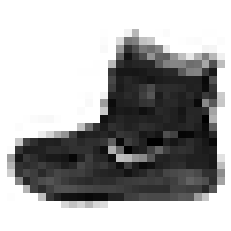

Ankle boot


In [4]:
plt.imshow(X_train[0],cmap='binary')
plt.axis('off')
plt.show()
print(class_names[y_train[0]])

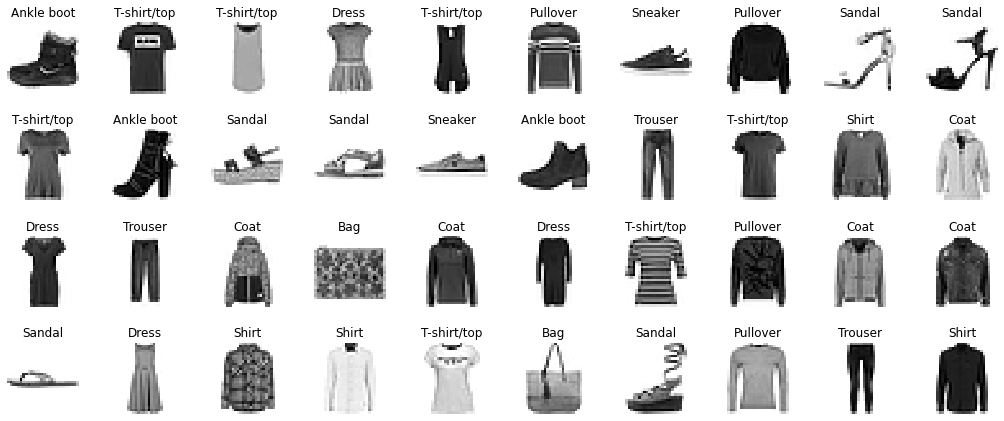

In [5]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Designing the classifier

We design the neural network using Convolutional, Pooling, and Dense layers. We also use dropout and Batch Normalization.

The resulting neural network has roughly the same number of parameters $(\sim 400,000)$ as the MLP. It reaches a train set

accuracy of 93\% vs the MLP accuracy of 88.6\%.

In [26]:
regularizer = tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-4)
def build_model(inputShape,n_classes):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(32, (3, 3), padding="same", activation="relu",
               kernel_regularizer=regularizer)(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (3, 3), padding="same", activation="relu",
               kernel_regularizer=regularizer)(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # prepare the final outputs, x will have shape (mb,n_h,n_w,n_f)
    n_h, n_w = x.shape[1:3]
    unrolled= Conv2D(128,(n_h,n_w),padding='valid',activation='relu',
                    kernel_regularizer=regularizer)(x)
    unrolled = BatchNormalization()(unrolled)
    unrolled = Conv2D(64,(1,1),padding='valid',activation='relu',
                     kernel_regularizer=regularizer)(unrolled)
    unrolled = Flatten()(unrolled)
    output = Dense(n_classes,activation='softmax')(unrolled)
    # build the model
    model = Model(inputs, output)
    # return the model to the calling function
    return model

In [7]:
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)

In [27]:
numclasses = len(np.unique(y_train))
model=build_model(X_train[0].shape,numclasses)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
              metrics =['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 64)          0   

Note the Conv2D layers of shape (1,1,128) and (1,1,64) adjactent to the output layer. These replace the 128 and 64 dimensional dense layers in our previous convnet. As a check, the number of parameters and trainable parameters is the same as before.

# Training the Neural Network

We now train the model using $\mathtt{model.fit}$. Note the argument _validation_split_ passed to this function. 

In [16]:
epochs = 20
batch_size = 32

history = model.fit(X_train,y_train,validation_split=0.1,
                    epochs=epochs,batch_size = batch_size)

Epoch 1/20
1688/1688 [==============================] - 82s 49ms/step - loss: 0.4987 - accuracy: 0.8614 - val_loss: 0.5092 - val_accuracy: 0.8608
Epoch 2/20
1688/1688 [==============================] - 79s 47ms/step - loss: 0.4268 - accuracy: 0.8968 - val_loss: 0.4529 - val_accuracy: 0.8883
Epoch 3/20
1688/1688 [==============================] - 79s 47ms/step - loss: 0.4184 - accuracy: 0.9054 - val_loss: 0.4873 - val_accuracy: 0.8813
Epoch 4/20
1688/1688 [==============================] - 66s 39ms/step - loss: 0.4209 - accuracy: 0.9090 - val_loss: 0.4388 - val_accuracy: 0.9027
Epoch 5/20
1688/1688 [==============================] - 65s 39ms/step - loss: 0.4133 - accuracy: 0.9139 - val_loss: 0.4205 - val_accuracy: 0.9122
Epoch 6/20
1688/1688 [==============================] - 53s 31ms/step - loss: 0.4086 - accuracy: 0.9157 - val_loss: 0.4274 - val_accuracy: 0.9125
Epoch 7/20
1688/1688 [==============================] - 64s 38ms/step - loss: 0.4011 - accuracy: 0.9202 - val_loss: 0.4136 -

# Results

We reached a training loss of about 0.33 and validation loss of 0.37. Regularization, Dropout and Batch Normalization mitigate overfitting in the neural network. Indeed the model reaches an accuracy of 0.94 on the train data while the accuracy on the validation data is 0.93, roughly comparable.

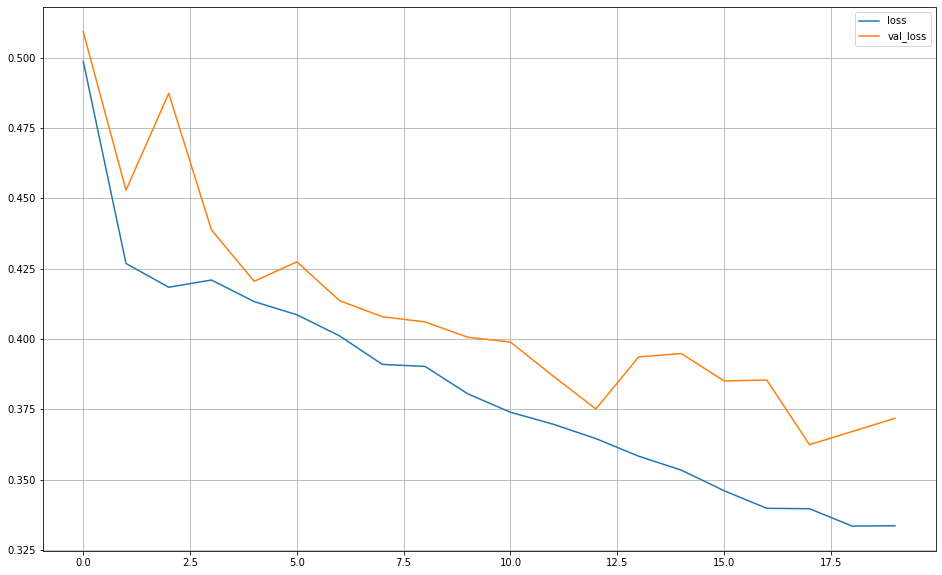

In [17]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(16, 10))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

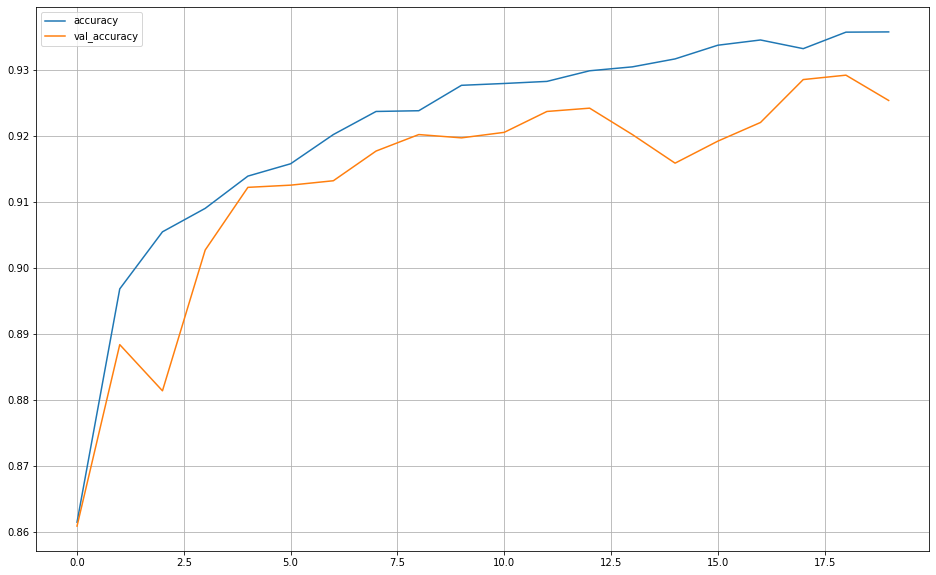

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(16, 10))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## Evaluating the model

The validation data above was supposed to be a placeholder for actual unseen data. We estimate that the model should reach a loss of 0.37 and an accuracy of 0.93 on unseen data.

We can check this by evaluating the model on test data. The actual numbers are not too far off from our expectations. The loss is 0.38 and the accuracy is 0.93

In [19]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 5s 17ms/step - loss: 0.3832 - accuracy: 0.9266
Test loss: 0.38320061564445496
Test accuracy: 0.9265999794006348


In [20]:
y_pred = np.argmax(model.predict(X_test),axis=-1)
y_test_ordinal = np.argmax(y_test,axis=-1)

# Analyzing Results

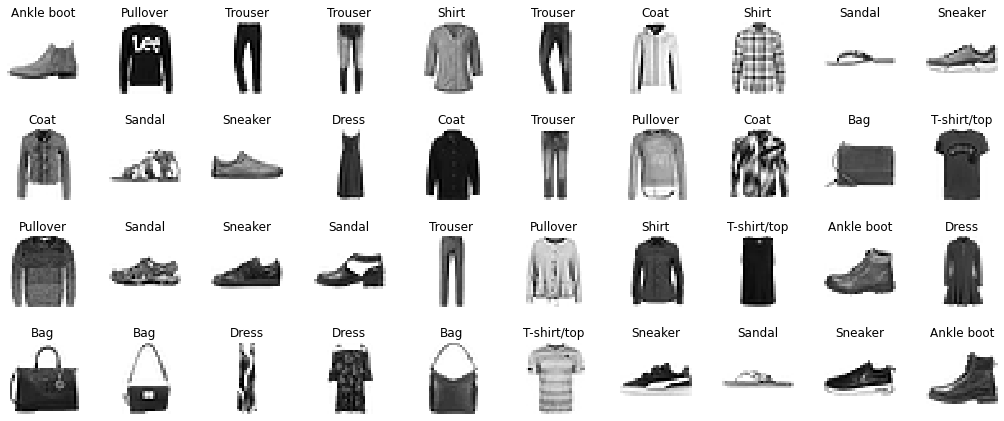

In [21]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.squeeze(X_test[index]), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Enumerating Misclassifications

In [22]:
misclassified=np.where(y_pred!=y_test)[0]
X_misclassified = X_test[misclassified]
y_misclassified = y_pred[misclassified]

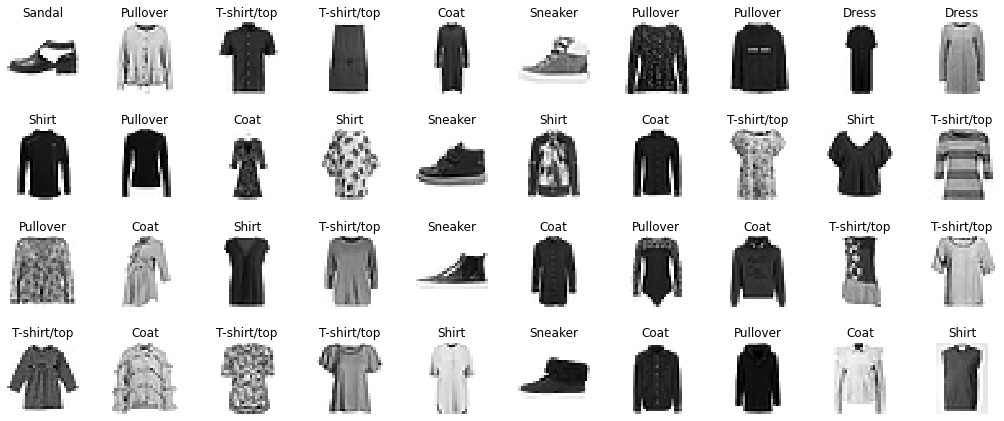

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.8, n_rows * 1.8))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.squeeze(X_misclassified[index]), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_misclassified[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [24]:
print(confusion_matrix(y_test,y_pred))

[[916   0  24  12   1   1  41   0   5   0]
 [  1 977   1  17   1   0   1   0   2   0]
 [ 19   0 904   5  52   0  20   0   0   0]
 [ 13   0  11 919  39   0  15   0   3   0]
 [  0   0  28  12 929   0  30   0   1   0]
 [  0   0   0   0   0 970   0  25   0   5]
 [112   1  65  18  84   0 713   0   7   0]
 [  0   0   0   0   0   1   0 984   0  15]
 [  1   0   1   3   1   1   1   2 990   0]
 [  0   0   0   0   0   3   1  32   0 964]]
